# Introduction

This exercise makes use of the database you created in `Exercise02` and the BEL statement parsers you write with regular expressions in `Reading_searching_sending.ipynb`.

In [1]:
import pandas as pd
import os, json, re, time
time.asctime()

'Thu Oct  6 09:22:38 2016'

In [2]:
base = os.path.join(os.environ['BUG_FREE_EUREKA_BASE'])
base

'/Users/alex/bit/bug-free-eureka'

# Task 1

This exercise is about loading the HGNC data to create a dictionary from HGNC symbols to set of enzyme ID's.

## 1.1 Load Data

Load json data from `/data/exercise02/hgnc_complete_set.json`.

In [3]:
data_path = os.path.join(base, 'data', 'exercise02', 'hgnc_complete_set.json')
with open(data_path) as f:
    hgnc_json = json.load(f)

## 1.2 Reorganize Data into `pd.DataFrame`

Identify the relevant subdictionaries in your `dictionary -> response -> docs`. Load them to a data frame, 
then create a new data frame with just the HGNC symbol and Enzyme ID

In [4]:
df_hgnc = pd.DataFrame(hgnc_json['response']['docs'])

In [5]:
df_hgnc.columns

Index(['_version_', 'alias_name', 'alias_symbol', 'bioparadigms_slc',
       'ccds_id', 'cd', 'cosmic', 'date_approved_reserved', 'date_modified',
       'date_name_changed', 'date_symbol_changed', 'ena', 'ensembl_gene_id',
       'entrez_id', 'enzyme_id', 'gene_family', 'gene_family_id', 'hgnc_id',
       'homeodb', 'horde_id', 'imgt', 'intermediate_filament_db', 'iuphar',
       'kznf_gene_catalog', 'lncrnadb', 'location', 'location_sortable',
       'locus_group', 'locus_type', 'lsdb', 'mamit-trnadb', 'merops', 'mgd_id',
       'mirbase', 'name', 'omim_id', 'orphanet', 'prev_name', 'prev_symbol',
       'pseudogene.org', 'pubmed_id', 'refseq_accession', 'rgd_id',
       'snornabase', 'status', 'symbol', 'ucsc_id', 'uniprot_ids', 'uuid',
       'vega_id'],
      dtype='object')

## 1.3 Build dictionary for lookup

Iterate over this dataframe to build a dictionary that is `{hgnc symbol: set of enzyme id's}`. Call this dictionary `symbol2ec`

In [6]:
df_hgnc_sliced = df_hgnc[['symbol', 'enzyme_id']]
df_hgnc_sliced.head(50)

,symbol,enzyme_id
0,A1BG,NaN
1,A1BG-AS1,NaN
2,A1CF,NaN
3,A2M,NaN
4,A2M-AS1,NaN
5,A2ML1,NaN
6,A2ML1-AS1,NaN
7,A2ML1-AS2,NaN
8,A2MP1,NaN
9,A3GALT2,NaN


In [7]:
symbol2ec = {}

for idx, symbol, enzyme_ids in df_hgnc_sliced.itertuples():
    # we iterating over tuples, but there are much more
    # it is a method, so we need to put ()
    if isinstance(enzyme_ids, list):
        symbol2ec[symbol] = enzyme_ids
        # set membership could be looked very quickly!
        # it uses hashing functions, so you can look in very quickly
    else:
        symbol2ec[symbol] = []

In [8]:
'AKT1' in symbol2ec
'AKT1' in symbol2ec.keys()
# it automatically transformes it to keys

True

In [9]:
for k, v in zip(symbol2ec, range(5)):
    print(k)

MIR1245A
PCNX2
PSMA7P
CD96
RNA5SP221


# Task 2

This subexercise is about validating protein and kinase activity statements in BEL. Refer to last Thursday's work in `Reading_searching_sending.ipynb`.

## 2.1 Valid HGNC

Write a function, `valid_hgnc(hgnc_symbol, symbol2ec_instance)` that takes a name and the dictionary from Task 1.3 and returns whether this is a valid name

In [54]:
def valid_hgnc(hgnc_symbol, symbol2ec_instance):
    if not isinstance(hgnc_symbol, str):
        raise ValueError('input is not str')
    return hgnc_symbol in symbol2ec_instance

# assert valid_hgnc('AKT1', symbol2ec)
# assert not valid_hgnc('blabla', symbol2ec)
print(valid_hgnc('AKT1', symbol2ec))
print(valid_hgnc(123, symbol2ec))

True


ValueError: input is not str

## 2.2 Valid Kinase Activity

Write a function, `valid_kinase(hgnc_symbol, symbol2ec_instance)` that takes a name and the dictionary from Task 1.3 and returns whether this protein has kinase activity. Hint: an enzyme code reference can be found [here](http://brenda-enzymes.org/ecexplorer.php?browser=1&f[nodes]=132&f[action]=open&f[change]=153)

In [41]:
def valid_kinase(hgnc_symbol, symbol2ec_instance):
    """
    Check if symbol is valid hgnc and if it is a kinase.
    :param hgnc_symbol: a string representing a HGNC symbol
    :param symbol2ec_instance: a dictionary of {HGNC symbol: set of EC codes}
    """
    if not valid_hgnc(hgnc_symbol, symbol2ec_instance):
        return False
    for ec_id in symbol2ec_instance[hgnc_symbol]:
        return ec_id.startswith('2.7.')
    # rewrite with any() function
    return False
                

assert valid_kinase('AKT1', symbol2ec)
assert not valid_kinase('ABALON', symbol2ec)
assert not valid_kinase('AANAT', symbol2ec)

In [ ]:
match_protein = # name only
match_kin = # name only

def validate_bel_term(term, symbol2ec_instance):
    m = match_protein.match(term)
    if m:
        mm = m.gruodict()
        symbol = mm['name']
        return avlid_hgnc(symbol, symbol2ec_instance)
    
    m = match_kin.match(term)
    if m:
        mk = m.groupdict()
        symbol = mk['name']
        return valid_kinase(symbol, symbol2ec_instance)
    return False

## 2.3 Putting it all together

Write a function, `validate_bel_term(term, symbol2ec_instance)` that parses a BEL term about either a protein, or the kinase activity of a protein and validates it.

```python
def validate_bel_term(term, symbol2ec_instance):
    pass
```

### Examples

```python
>>> # check that the proteins have valid HGNC codes
>>> validate_bel_term('p(HGNC:APP)', symbol2ec)
True
>>> validate_bel_term('p(HGNC:ABCDEF)', symbol2ec)
False
>>> # check that kinase activity annotations are only on proteins that are
>>> # actually protein kinases (hint: check EC annotation)
>>> validate_bel_term('kin(p(HGNC:APP))', symbol2ec)
False
>>> validate_bel_term('kin(p(HGNC:AKT1))', symbol2ec)
True
```

In [12]:
pattern = re.compile('^(?P<if_kinase>kin)*\(*p\((?P<namespace_object>\w+)\:(?P<protein_object>\w+)\)\)*$')

def validate_bel_term(term, symbol2ec_instance):
    dct_regex_eval = pattern.match(term).groupdict()
    return_cond = False
    if dct_regex_eval['namespace_object'] == 'HGNC':
        symbol = dct_regex_eval['protein_object']
        return_cond = valid_hgnc(symbol, symbol2ec_instance)
    if dct_regex_eval['if_kinase'] == 'kin':
        return_cond = valid_kinase(symbol, symbol2ec_instance)
    return return_cond
    

assert validate_bel_term('p(HGNC:APP)', symbol2ec)
assert validate_bel_term('kin(p(HGNC:AASDHPPT))', symbol2ec)
assert not validate_bel_term('p(HGNC:ABCDEF)', symbol2ec)
assert not validate_bel_term('kin(p(HGNC:APP))', symbol2ec)

# Task 3

This task is about manual curation of text. You will be guided through translating the following text into BEL statements as strings within a python list.

## Document Definitions

Recall citations are written with source, title, then identifier as follows:

```
SET Citation = {"PubMed", "Nat Cell Biol 2007 Mar 9(3) 316-23", "17277771"}
```

Use these annotations and these namespaces:

```
DEFINE NAMESPACE HGNC AS URL "http://resource.belframework.org/belframework/20131211/namespace/hgnc-human-genes.belns"

DEFINE ANNOTATION CellLocation as LIST {"cell nucleus", "cytoplasm", "endoplasmic reticulum"}
```


## Source Text

> The following statements are from the document "BEL Exercise" in edition 00001 of the PyBEL Journal.

> The kinase activity of PI3k causes the increased abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 in the cytoplasm, 
> but only the increased expression of AKT serine/threonine kinase 1 in the endoplasmic reticulum. 
> Additionally, the abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 were found to be positively correlated in the cell nuclei.
> AKT serine/threonine kinase 2 increases GSK3 Beta in all of the nuclei, cytoplasm, and ER.

In [13]:
definition_statements = [
    'SET DOCUMENT name = "BEL Exercise"'
    'DEFINE NAMESPACE HGNC AS URL "http://resource.belframework.org/belframework/20131211/namespace/hgnc-human-genes.belns"',
    'DEFINE ANNOTATION CellLocation AS LIST {"cell nucleus", "cytoplasm", "endoplasmic reticulum"}',
    # definition area
]

In [14]:
def get_symbol(name_in):
    return list(df_hgnc[df_hgnc.symbol==name_in]['symbol'])[0]
get_symbol('PIK3CA')

'PIK3CA'

In [15]:
# hint: there should be 11 statements from this text
your_statements = [
    'SET Citation = {"PubMed", "", "PubMedID"}',
    'SET Evidence = {The kinase activity of PI3k causes the increased abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 in the cytoplasm, but only the increased expression of AKT serine/threonine kinase 1 in the endoplasmic reticulum. Additionally, the abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 were found to be positively correlated in the cell nuclei. AKT serine/threonine kinase 2 increases GSK3 Beta in all of the nuclei, cytoplasm, and ER.}',
    'SET CellLocation = "cytoplasm"',
    'kin(p(HGNC:PIK3CA)) increases p(HGNC:AKT1)',
    'kin(p(HGNC:PIK3CA)) increases p(HGNC:AKT2)',
    'SET CellLocation = "endoplasmic reticulum"',
    'kin(p(HGNC:PIK3CA)) increases p(HGNC:AKT1)',
    'SET CellLocation = "cell nucleus"',
    'p(HGNC:AKT1) positiveCorrelation p(HGNC:AKT2)',
    'SET CellLocation = {"cell nucleus", "cytoplasm", "endoplasmic reticulum"}',
    'p(HGNC:AKT2) increases p(HGNC:GSK3B)',
]

In [23]:
statements = definition_statements + your_statements
statements

['SET DOCUMENT name = "BEL Exercise"DEFINE NAMESPACE HGNC AS URL "http://resource.belframework.org/belframework/20131211/namespace/hgnc-human-genes.belns"',
 'DEFINE ANNOTATION CellLocation AS LIST {"cell nucleus", "cytoplasm", "endoplasmic reticulum"}',
 'SET Citation = {"PubMed", "", "PubMedID"}',
 'SET Evidence = {The kinase activity of PI3k causes the increased abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 in the cytoplasm, but only the increased expression of AKT serine/threonine kinase 1 in the endoplasmic reticulum. Additionally, the abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 were found to be positively correlated in the cell nuclei. AKT serine/threonine kinase 2 increases GSK3 Beta in all of the nuclei, cytoplasm, and ER.}',
 'SET CellLocation = "cytoplasm"',
 'kin(p(HGNC:PIK3CA)) increases p(HGNC:AKT1)',
 'kin(p(HGNC:PIK3CA)) increases p(HGNC:AKT2)',
 'SET CellLocation = "endoplasmic reticulum"',
 'kin(p(HGNC:PIK

# Task 4

This task is again about regular expressions. Return to `Reading_searching_sending.ipynb` and find your regular expressions that parse the subject, predicate, and object from a statement like `p(HGNC:AKT1) pos p(HGNC:AKT2)`

## 4.1 Validating Statements

Write a function `validate_bel_statement(statement, symbol2ec)` that takes a subject, predicate, object BEL statement as a string and determines if it its subject and objects are valid.

In [24]:
valid_kinase('kin(p(HGNC:PIK3CA))', symbol2ec)

False

In [63]:
bel_pattern = re.compile('^(?P<subject>(?P<subject_activity>\w+)*\(*(?P<subject_abundance_type>\w+)\((?P<subject_namespace>\w+)\:(?P<subject_protein>\w+)\)\)*)\s+(?P<relation_type>[\w\W]+)\s+(?P<object>(?P<object_activity>\w+)*\(*(?P<object_abundance_type>\w+)\((?P<object_namespace>\w+)\:(?P<object_protein>\w+)\)\)*)$')

In [47]:
def validate_bel_statement(statement, symbol2ec_instance):
    """
    Validate the syntax and semantics of a relation
    :param relation: a BEL relation
    :type relation: str
    :rtype: bool
    """
    bel_re = bel_pattern.match(statement)
    if not bel_re:
        return False
    dct_bel = bel_re.groupdict()
    
    return_cond = False
    if dct_bel['subject_namespace'] == 'HGNC' and dct_bel['object_namespace'] == 'HGNC':
        return_cond = valid_hgnc(dct_bel['subject_protein'], symbol2ec_instance)
        return_cond = valid_hgnc(dct_bel['object_protein'], symbol2ec_instance)
        if dct_bel['subject_activity'] == 'kin':
            return_cond = valid_kinase(dct_bel['subject_protein'], symbol2ec_instance)
        elif dct_bel['object_activity'] == 'kin':
            return_cond = valid_kinase(dct_bel['object_protein'], symbol2ec_instance)
    return return_cond

In [55]:
valid_relations = {
    'increases',
    'decreases',
    'directlyIncreases',
    'directlyDecreases',
    'positiveCorrelation',
    'negativeCorrelation',
}

In [ ]:
bel_pattern = re.compile('^(?P<subject>(?P<subject_activity>\w+)*\(*(?P<subject_abundance_type>\w+)\((?P<subject_namespace>\w+)\:(?P<subject_protein>\w+)\)\)*)\s+(?P<relation_type>[\w\W]+)\s+(?P<object>(?P<object_activity>\w+)*\(*(?P<object_abundance_type>\w+)\((?P<object_namespace>\w+)\:(?P<object_protein>\w+)\)\)*)$')

In [ ]:
bel_pattern_akrishta = re.compile('^(?P<subject>(?P<subject_activity>\w+)*\(*(?P<subject_abundance_type>\w+)\((?P<subject_namespace>\w+)\:(?P<subject_protein>\w+)\)\)*)\s+(?P<relation_type>[\w\W]+)\s+(?P<object>(?P<object_activity>\w+)*\(*(?P<object_abundance_type>\w+)\((?P<object_namespace>\w+)\:(?P<object_protein>\w+)\)\)*)$')

In [56]:
import logging

log = logging.getLogger(__name__)

def validate_bel_statement(statement, symbol2ec_instance):
    """
    Validate the syntax and semantics of a relation
    :param relation: a BEL relation
    :type relation: str
    :rtype: bool
    """
    mr = bel_pattern.match(statement)
    if not bel_re:
        log.warning('No valid statement')
        return False
    mrg = mr.groupdict()
    
    if not valid_hgnc(mrg['sp'], symbol2ec_instance):
        return False
    
    if mrg['sp'] is None and mrg['sk'] is None:
        log.warning('No valid subject')
        return False
    
    if mrg['op'] is None and mrg['ok'] is None:
        log.warning('No valid obbject')
        return False
    
    if mrg['sk'] is None:
        if not valid_hgnc(mrg['sp'], symbol2ec_instance):
            return False
    else:
        if not valid_kinase(mrg['sk'], symbol2ec_instance):
            return False
    
    if mrg['ok'] is None:
        if not valid_hgnc(mrg['op'], symbol2ec_instance):
            log.warning('Semantically invalid subject')
            return False
    else:
        if not valid_kinase(mrg['ok'], symbol2ec_instance):
            log.warning('Semantically invalid object')
            return False
    
    if mgr['relation'] not in valid_relations:
        log.warning('Invalid relation')
        return False
    
    return True

another solutions:

In [42]:
match_both = re.compile('(p\(HGNC:(?P<prot>\w+)\))|(kin\(p\(HGNC:(?P<kin>\w+)\))\)')
match_both.match('kin(p(HGNC:ABC))').groupdict()

{'kin': 'ABC', 'prot': None}

In [46]:
re.search('(A)\s+(B(d*))\s+(C)', 'A Bdd C').groups()

('A', 'Bdd', 'dd', 'C')

## 4.2 Validating Your Statements

Run this cell to validate the BEL statements you've written.

In [26]:
for statement in your_statements:
    valid = validate_bel_statement(statement, symbol2ec)
    print('{} is {}valid'.format(statement, '' if valid else 'in'))

Not matched, so...
SET Citation = {"PubMed", "", "PubMedID"} is invalid
Not matched, so...
SET Evidence = {The kinase activity of PI3k causes the increased abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 in the cytoplasm, but only the increased expression of AKT serine/threonine kinase 1 in the endoplasmic reticulum. Additionally, the abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 were found to be positively correlated in the cell nuclei. AKT serine/threonine kinase 2 increases GSK3 Beta in all of the nuclei, cytoplasm, and ER.} is invalid
Not matched, so...
SET CellLocation = "cytoplasm" is invalid
kin(p(HGNC:PIK3CA)) increases p(HGNC:AKT1) is valid
kin(p(HGNC:PIK3CA)) increases p(HGNC:AKT2) is valid
Not matched, so...
SET CellLocation = "endoplasmic reticulum" is invalid
kin(p(HGNC:PIK3CA)) increases p(HGNC:AKT1) is valid
Not matched, so...
SET CellLocation = "cell nucleus" is invalid
p(HGNC:AKT1) positiveCorrelation p(HGNC:A

## 4.3 Visualization

Use `pybel` to visualize the network.

In [27]:
try:
    import pybel
    import networkx
    
    g = pybel.from_bel(statements)
    nx.draw_spring(g, with_labels=True)
except:
    print('PyBEL not installed')

PyBEL not installed


In [28]:
%whos

Variable                 Type             Data/Info
---------------------------------------------------
base                     str              /Users/alex/bit/bug-free-eureka
bel2dict                 function         <function bel2dict at 0x1225b7a60>
current_dct              dict             n=9
data_path                str              /Users/alex/bit/bug-free-<...>02/hgnc_complete_set.json
definition_statements    list             n=2
df_hgnc                  DataFrame                         _version<...>[41049 rows x 50 columns]
df_hgnc_sliced           DataFrame                    symbol       <...>n[41049 rows x 2 columns]
dg_bel                   DiGraph          
enzyme_ids               float            nan
f                        TextIOWrapper    <_io.TextIOWrapper name='<...>ode='r' encoding='UTF-8'>
get_symbol               function         <function get_symbol at 0x11f5c4e18>
hgnc_json                dict             n=2
i                        str              objec

## Hometask: Generating a graph

In [16]:
import networkx as nx
%matplotlib inline

In [17]:
pattern = re.compile('^(?P<subject>(?P<subject_activity>\w+)*\(*(?P<subject_abundance_type>\w+)\((?P<subject_namespace>\w+)\:(?P<subject_protein>\w+)\)\)*)\s+(?P<relation_type>[\w\W]+)\s+(?P<object>(?P<object_activity>\w+)*\(*(?P<object_abundance_type>\w+)\((?P<object_namespace>\w+)\:(?P<object_protein>\w+)\)\)*)$')
def bel2dict(statement):
    if pattern.match(statement) is not None:
        dct_regex_eval = pattern.match(statement).groupdict()
        return dct_regex_eval

In [18]:
statements_to_graph = [
    'kin(p(HGNC:PIK3CA)) increases p(HGNC:AKT1)',
    'kin(p(HGNC:PIK3CA)) increases p(HGNC:AKT2)',
    'kin(p(HGNC:PIK3CA)) increases p(HGNC:AKT1)',
    'p(HGNC:AKT1) positiveCorrelation p(HGNC:AKT2)',
    'p(HGNC:AKT2) increases p(HGNC:GSK3B)',
]

In [30]:
bel2dict(statements_to_graph[0])

{'object_abundance_type': 'p',
 'object_activity': None,
 'object_namespace': 'HGNC',
 'object_protein': 'AKT1',
 'relation_type': 'increases',
 'subject_abundance_type': 'p',
 'subject_activity': 'kin',
 'subject_namespace': 'HGNC',
 'subject_protein': 'PIK3CA'}

In [59]:
dg_bel = nx.MultiDiGraph()
for statement in statements_to_graph:
    current_dct = bel2dict(statement)
    for i in ['subject', 'object']:
        dg_bel.add_node(current_dct['{}_protein'.format(i)],activity=current_dct['{}_activity'.format(i)],ab_type=current_dct['{}_abundance_type'.format(i)])
    if current_dct['relation_type'] == 'positiveCorrelation':
        dg_bel.add_edge(current_dct['subject_protein'], current_dct['object_protein'], relation=current_dct['relation_type'])
        dg_bel.add_edge(current_dct['object_protein'], current_dct['subject_protein'], relation=current_dct['relation_type'])
    else:
        dg_bel.add_edge(current_dct['subject_protein'], current_dct['object_protein'], relation=current_dct['relation_type'])

In [50]:
dg_bel.nodes(data=True)

[('GSK3B', {'ab_type': 'p', 'activity': None}),
 ('PIK3CA', {'ab_type': 'p', 'activity': 'kin'}),
 ('AKT2', {'ab_type': 'p', 'activity': None}),
 ('AKT1', {'ab_type': 'p', 'activity': None})]

In [51]:
dg_bel.edges(data=True)

[('PIK3CA', 'AKT2', {'relation': 'increases'}),
 ('PIK3CA', 'AKT1', {'relation': 'increases'}),
 ('AKT2', 'GSK3B', {'relation': 'increases'}),
 ('AKT2', 'AKT1', {'relation': 'positiveCorrelation'}),
 ('AKT1', 'AKT2', {'relation': 'positiveCorrelation'})]

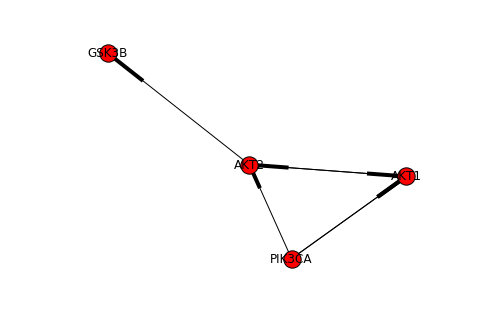

In [60]:
nx.draw(dg_bel, with_labels=True)

1. encode as a graph
2. transcription factor can bind: often bind to several genes, can activate them at once
 - TP increases abundance of RNA of protein A and RNA of protein B;
 - and here there is a modification

- nested statements:
    - split every statement into single statements

## Work in class

In [57]:
import networkx as nx

In [64]:
G = nx.MultiDiGraph()

if validate_bel_statement(statements_to_graph[0], symbol2ec):
    mrg = bel_pattern.match(statement).groupdict()
    print(mrg)
    
    rel = mrg['relation']
    
    if mrg['sk'] is N
    sub_name = 
    obj_name = 
    
    
    G.add_node(sub_name)
    G.add_node(obj_name)
    G.add_edge(sub_name, obj_name, rel='rel')
# # take my_rel and put nodes and edge in this graph

NameError: name 'bel_re' is not defined